In [ ]:
from utils import *

NOTEBOOK_ID = '20'
RUN_MODELS = False

# train/test ADhunter v1 on Sanborn dataset

In [2]:
if not os.path.isfile(f'{DATASET_DIR}/02-sanborn/sanborn_data.csv'):
    sanborn_test_df = pd.read_excel(f'{DATASET_DIR}/02-sanborn/elife-68068-fig3-data1-v3.xlsx',sheet_name='PADDLE test set predictions')[['protein sequence','activation','Z score']].dropna()
    sanborn_test_df = sanborn_test_df.rename(columns={'protein sequence':'AAseq','Z score':'zscore'})
    sanborn_test_df['dataset'] = 'test'
    sanborn_train_df = pd.read_excel(f'{DATASET_DIR}/02-sanborn/elife-68068-fig1-data1-v3.xlsx',sheet_name='TF tiles, see Fig 1')[['protein sequence','activation','Z score']].dropna()
    sanborn_train_df = sanborn_train_df.rename(columns={'protein sequence':'AAseq','Z score':'zscore'})
    sanborn_train_df = sanborn_train_df[~sanborn_train_df['AAseq'].isin(sanborn_test_df['AAseq'])]
    sanborn_train_df['dataset'] = 'train'
    sanborn_df = pd.concat([sanborn_train_df,sanborn_test_df]).reset_index(drop=True)
    sanborn_df.to_csv(f'{DATASET_DIR}/02-sanborn/sanborn_data.csv',index=False)
else:
    sanborn_df = pd.read_csv(f'{DATASET_DIR}/02-sanborn/sanborn_data.csv')
sanborn_df

,AAseq,activation,zscore,dataset
0,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,57.55,9.94,train
1,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,57.04,9.92,train
2,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,64.50,10.22,train
3,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,70.85,10.45,train
4,SIDSAAHHDNSTIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPN...,55.19,9.84,train
...,...,...,...,...
8240,AQGNRDFHAPFTDFLVQNGIGHDMSHLGAIPRSTEPGTMNDLNGTA...,2.58,2.33,test
8241,GGNGGHFSAPLTDILMHNAIGDHLHLGGLGDFSETVNVADIPGASH...,7.28,4.87,test
8242,GNGGHFNAPLTDILMHNAIGGENFHLGGMGDFAPSMNLPDLHGAGH...,3.03,2.72,test
8243,VTNRGNTNLYDHAVTPEILLEQLAYVDNFIPSLDNEFSNVDWNVNT...,30.87,8.41,test


In [ ]:
if RUN_MODELS:
    for target_col in ['activation','zscore']:
        X = np.asarray([[aa_to_i[aa] for aa in x] for x in sanborn_df['AAseq']])
        y = sanborn_df[target_col].to_numpy()
        threshold = sanborn_df[target_col].median()
        dataset,_ = split_dataset(X,y,threshold)
        train_ADhunter(dataset,out_dir=f'{COMPARE_SANBORN_DIR}',out_name=f'sanborn_{target_col}',version='v1',random_state=0)
        test_ADhunter(dataset,out_dir=f'{COMPARE_SANBORN_DIR}',out_name=f'sanborn_{target_col}',version='v1',random_state=0)

# evaluate Sanborn dataset

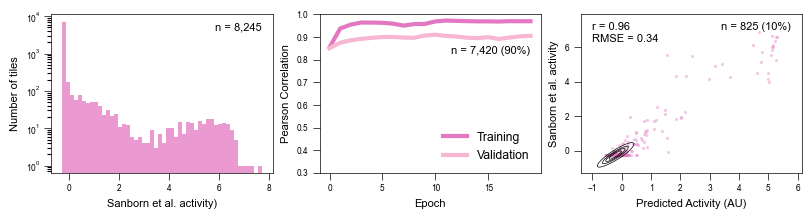

In [4]:
fig = plt.figure(figsize=(8,10),constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=6, figure=fig)

target_col = 'activation'
tmp_df = sanborn_df.copy()
activity = tmp_df[target_col].to_numpy()
thresh = tmp_df[target_col].median()
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)
tmp_df[target_col] = y_cont 

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
train_df = pd.read_pickle(f'{SANBORN_DIR}/03-results/ADhunter_v1-sanborn_{target_col}_state0_train_df.pkl')
test_df = pd.read_pickle(f'{SANBORN_DIR}/03-results/ADhunter_v1-sanborn_{target_col}_state0_test_df.pkl')
n_total = len(tmp_df)
n_test = len(test_df)
n_train = n_total - n_test
color1_idx, color2_idx = COLOR_PAIRS[5]
color1, color2 = COLORS[color1_idx], COLORS[color2_idx]
g = sns.histplot(data=tmp_df,x=target_col,ax=ax0,color=color1,element='step',bins=50,edgecolor=None)

ax0.text(0.95,0.95,ha='right',va='top',s=f'n = {format(n_total,",")}',transform=ax0.transAxes)
ax0.set(xlabel='Sanborn et al. activity)',yscale='log',ylabel='Number of tiles')
plot_train_val(train_df,ax1,color1,color2)
ax1.text(0.95, 0.8, ha='right',va='top',s =f'n = {int(n_train):,d} ({(n_train/n_total)*100:.0f}%)',transform=ax1.transAxes)

pearson_corr = plot_test(test_df, ax2, color1)
correlation_matrix = np.corrcoef(test_df['y_test_hat'], test_df['y_test'])
r2 = r2_score(test_df['y_test_hat'],test_df['y_test'])
rmse = mean_squared_error(test_df['y_test_hat'],test_df['y_test'],squared=False)
plt.ylabel('Sanborn et al. activity')

ax2.text(0.95, 0.95, ha='right',va='top',s =f'n = {int(n_test):,d} ({(n_test/n_total)*100:.0f}%)',transform=ax2.transAxes)
ax2.text(0.05, 0.95, ha='left',va='top',s =f'r = {pearson_corr:.2f}\nRMSE = {rmse:.2f}',transform=ax2.transAxes)

if SAVE_FIGURES:
    fig.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-sanborn_target_comparison.png',dpi=400,transparent=False,bbox_inches='tight')

In [5]:
train_df, test_df = parse_results(f'{SANBORN_DIR}/03-results')
calculate_metrics_from_df(test_df).sort_values('pearson_corr')

,params,pearson_corr,spearman_corr,R2,RMSE
1,ADhunter_v1-sanborn_zscore_state0,0.93,0.61,0.82,0.35
0,ADhunter_v1-sanborn_activation_state0,0.96,0.38,0.84,0.34


# compare ADhunter v1 vs PADDLE

In [6]:
if not os.path.isfile(f'{SANBORN_DIR}/03-results/model_performance_comparison.csv'):
    ratio_test_df = get_test_results('Activity_500k_Rat')
    gfp_test_df = get_test_results('Activity_500k_G')
    gfp_mil_test_df = get_test_results('Activity_1mil_G')

    performance_dict = {}
    performance_dict[('Activity_500k_Rat','ADhunter')] = calculate_performance(ratio_test_df,'y_test','y_test_hat')
    performance_dict[('Activity_500k_Rat','PADDLE activation')] = calculate_performance(ratio_test_df,'y_test','Predicted_activation_PADDLE')
    performance_dict[('Activity_500k_Rat','PADDLE zscore')] = calculate_performance(ratio_test_df,'y_test','Z-score_PADDLE')
    performance_dict[('Activity_500k_G','ADhunter')] = calculate_performance(gfp_test_df,'y_test','y_test_hat')
    performance_dict[('Activity_500k_G','PADDLE activation')] = calculate_performance(gfp_test_df,'y_test','Predicted_activation_PADDLE')
    performance_dict[('Activity_500k_G','PADDLE zscore')] = calculate_performance(gfp_test_df,'y_test','Z-score_PADDLE')
    performance_dict[('Activity_1mil_G','ADhunter')] = calculate_performance(gfp_mil_test_df,'y_test','y_test_hat')
    performance_dict[('Activity_1mil_G','PADDLE activation')] = calculate_performance(gfp_mil_test_df,'y_test','Predicted_activation_PADDLE')
    performance_dict[('Activity_1mil_G','PADDLE zscore')] = calculate_performance(gfp_mil_test_df,'y_test','Z-score_PADDLE')

    performance_df = pd.DataFrame(performance_dict).T.reset_index()
    performance_df.columns = ['test_target','model','pearson_correlation','r2','rmse']
    performance_df = performance_df.sort_values(['test_target','pearson_correlation'],ascending=True)
    performance_df.to_csv(f'{SANBORN_DIR}/03-results/model_performance_comparison.csv',index=False)
else:
    performance_df = pd.read_csv(f'{SANBORN_DIR}/03-results/model_performance_comparison.csv')
performance_df.sort_values('pearson_correlation')

,test_target,model,pearson_correlation,r2,rmse
6,Activity_500k_Rat,PADDLE activation,0.30,0.09,35.62
7,Activity_500k_Rat,PADDLE zscore,0.30,0.09,8.46
3,Activity_500k_G,PADDLE activation,0.39,0.15,35.09
0,Activity_1mil_G,PADDLE zscore,0.39,0.15,8.41
4,Activity_500k_G,PADDLE zscore,0.40,0.16,8.42
1,Activity_1mil_G,PADDLE activation,0.40,0.16,35.07
2,Activity_1mil_G,ADhunter,0.69,0.47,0.76
8,Activity_500k_Rat,ADhunter,0.75,0.57,0.75
5,Activity_500k_G,ADhunter,0.78,0.61,0.63
